# Differentially Private Machine Learning
* ## Demo for differentially private Naive Bayes classifier
* ## Task: differentially private K-means

### You need to install the IBM Differential Privacy Library 
The IBM Differential Privacy Library is a general-purpose library for experimenting, investigating and developing applications in differential privacy.

* #### Installation with pip

The library is designed to run with Python 3. The library can be installed from the PyPi repository using pip (or pip3):

pip install diffprivlib



* #### Manual installation

For the most recent version of the library, either download the source code or clone the repository in your directory of choice:

git clone https://github.com/IBM/differential-privacy-library

To install diffprivlib, do the following in the project folder (alternatively, you can run python3 -m pip install .):


pip install .

In [2]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Import the differential private library
import diffprivlib.models as dp

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB

In [3]:
# Load the 'income' dataset. As this data set is related to personal information, we think data analysis directly on the dataset will cause privacy issues.
raw_data = pd.read_csv("data/income.csv")
print("data size: "+str(raw_data.shape))
raw_data.head()

data size: (32561, 6)


,Age,Education Number,Capital Gain,Capital Loss,Hours per Week,Income
0,39,13,2174,0,40,<=50K
1,50,13,0,0,13,<=50K
2,38,9,0,0,40,<=50K
3,53,7,0,0,40,<=50K
4,28,13,0,0,40,<=50K


In [4]:
# Specifying features and target attribute
X = raw_data.drop(['Income'], axis='columns').values
y = raw_data['Income'].values

# Pre-processing with standardization
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = X_scaled

# Question: Given that the preprocessing transform the data, will it protect the privacy? 
"""
The privacy is occurred before the dataset is established.
Consent is required in advance to be used as a relevant dataset, and privacy is leaked (and of course, not a priority), so that information does not create data that can accurately identify a particular person.
Sensitive data also goes through the encryption phase before being stored as a dataset, which is not a big problem.

In conclusion, the preprocessing transform the data protects the privacy by encryption.
"""

## Naive Bayes with no privacy
To begin, let's first train a regular (non-private) naive Bayes classifier, and test its accuracy.

In [5]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [6]:
# Train a model
nonprivate_clf = GaussianNB()
nonprivate_clf.fit(X_train, y_train)

print("Non-private test accuracy: %.2f%%" % 
     (accuracy_score(y_test, nonprivate_clf.predict(X_test)) * 100))

# Note: If you built the model and do the testing again, the result will be the same.
# The NBC model is based on probability model (probabilistic ML model), but the algorithm is deterministic.

Non-private test accuracy: 79.76%


## Differentially private naive Bayes classification
Using the models.GaussianNB module of diffprivlib, we can train a naive Bayes classifier while satisfying differential privacy.
If we don't specify any parameters, the model defaults to epsilon = 1 and selects the model's feature bounds from the data. This throws a warning with .fit() is first called, as it leaks additional privacy. To ensure no additional privacy loss, we should specify the bounds as an argument, and choose the bounds indepedently of the data (i.e. using domain knowledge).

Questions: what kind of basic statistic compuing operations are used in Guassian NBC? What are the sensitivities of the operations?

In [7]:
# Train a differentially private version of NBC
stardardized_bounds = (0, 1) 

dp_clf = dp.GaussianNB(epsilon = 1, bounds=stardardized_bounds)

dp_clf.fit(X_train, y_train)

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" %
      (dp_clf.epsilon, accuracy_score(y_test, dp_clf.predict(X_test)) * 100))

# Note: If you built the model and do the testing again, the result will be different. 
# As we pointed in our lecture, the algorithm has been randomized.

Differentially private test accuracy (epsilon=1.00): 80.36%


In [8]:
# Try a different epsilon value epsilon=0.1 (stronger privayc preservation)
dp_clf = dp.GaussianNB(epsilon = 0.1, bounds=stardardized_bounds)

dp_clf.fit(X_train, y_train)

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
      (dp_clf.epsilon, accuracy_score(y_test, dp_clf.predict(X_test)) * 100))

Differentially private test accuracy (epsilon=0.10): 76.35%


In [9]:
# Try the extreme values like 0.0000001 (very strong privacy preservation), and inf (no privacy preservation)
dp_clf = dp.GaussianNB(epsilon = 0.0000001, bounds=stardardized_bounds)
#dp_clf = dp.GaussianNB(epsilon=float("inf"), bounds=stardardized_bounds)

dp_clf.fit(X_train, y_train)

print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
      (dp_clf.epsilon, accuracy_score(y_test, dp_clf.predict(X_test)) * 100))

Differentially private test accuracy (epsilon=0.00): 75.89%


## Investigate how epsilon affects prediction performance
We will visualize the relationship between epsilon and accuracy.

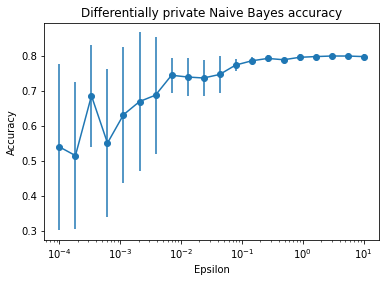

In [10]:
# For evaluation randomized algorithms, we need to run multiple execution, using the standard deviation to perceive the robustness of the prediction
accuracy_scores = []
accuracy_scores_std = []

epsilons = np.logspace(-4, 1, 20)

for epsilon in epsilons:
    # Multiple runs for stable indicators for randomized algorithms
    accuracy_scores_tmp = []
    
    n_iteration=10
    for j in range(0, n_iteration):
        dp_clf = dp.GaussianNB(epsilon=epsilon, bounds=stardardized_bounds)
        dp_clf.fit(X_train, y_train)
        accuracy_scores_tmp.append(accuracy_score(y_test, dp_clf.predict(X_test)))
    
    accuracy_scores.append(np.mean(accuracy_scores_tmp))
    accuracy_scores_std.append(np.std(accuracy_scores_tmp))

# Plot the relationship between the classification accuracy and the privacy budget epsilon
plt.errorbar(epsilons, accuracy_scores, yerr=accuracy_scores_std, marker='o')
plt.xscale('log')
plt.title('Differentially private Naive Bayes accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

## Task: differentially private K-means
You can refer to the configuration/implementation details for differentially private K-menas: https://github.com/IBM/differential-privacy-library/blob/master/diffprivlib/models/k_means.py

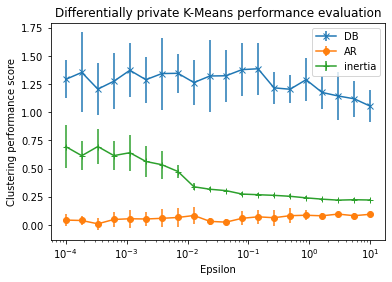

In [11]:
# Task 6.1 Study how eplison affects the clustering performance via visualizing the relationship between epsilon and the cluster performance indicators we used in Prac-5.
# You could fix value of K, e.g., 5, or 10
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score
db_scores = []
db_scores_std = []

ar_scores=[]
ar_scores_std=[]

inertia = []
inertia_std = []

epsilons = np.logspace(-4, 1, 20)

for i in epsilons: 
    db_scores_tmp = []
    ar_scores_tmp = []
    inertias_tmp = []
    n_iteration=10
    for j in range(0, n_iteration):
        kmeans = dp.KMeans(epsilon = i, bounds=stardardized_bounds,n_clusters=5)
        kmeans.fit(X)
        y_pred = kmeans.predict(X_test)
        labels = kmeans.labels_
        db_scores_tmp.append(davies_bouldin_score(X, labels))
        ar_scores_tmp.append(adjusted_rand_score(labels, y))
        inertias_tmp.append(math.sqrt(kmeans.inertia_/X.shape[0]))
        
    db_scores.append(np.mean(db_scores_tmp))
    db_scores_std.append(np.std(db_scores_tmp))
    ar_scores.append(np.mean(ar_scores_tmp))
    ar_scores_std.append(np.std(ar_scores_tmp))
    inertia.append(np.mean(inertias_tmp))
    inertia_std.append(np.std(inertias_tmp))

# Plot the relationship between the clustering performance indicators and the privacy budget epsilon
plt.errorbar(epsilons, db_scores, yerr=db_scores_std, marker='x', label='DB')
plt.errorbar(epsilons, ar_scores, yerr=ar_scores_std, marker='o', label='AR')
plt.errorbar(epsilons, inertia, yerr=inertia_std, marker='+', label='inertia')
        
plt.xscale('log')
plt.title('Differentially private K-Means performance evaluation')
plt.xlabel('Epsilon')
plt.ylabel('Clustering performance score')
plt.legend(loc='best')
plt.show()


In [ ]:
# Optional: visualize the orginal datasets (randomly/mannual/PCA selected two dimensions for visualization, showing how epsilon affects the clustering results)
